In [1]:
import os

import tensorflow as tf
from tensorflow.keras import Model, callbacks
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import (Dense, Dropout, GlobalAveragePooling2D,
                                     Input)
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Convolution2D,Activation,Flatten,Dense,Dropout,MaxPool2D,BatchNormalization


try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs
    strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
    #strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines

print("Number of accelerators: ", strategy.num_replicas_in_sync)

data_dir = "../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
train_dir = data_dir + "/train"
test_dir = data_dir + "/valid"
diseases = os.listdir(train_dir)
print("Total disease classes are: {}".format(len(diseases)))

train_datagen_aug = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   fill_mode="nearest",
                                   rotation_range = 20,
                                   width_shift_range=0.2,
                                    height_shift_range=0.2,
                                   horizontal_flip = True,
                                   validation_split=0.2) # set validation split


test_datagen_aug = ImageDataGenerator( rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   rotation_range = 20,
                                   horizontal_flip = True)


training_set_aug = train_datagen_aug.flow_from_directory(directory= train_dir,
                                               target_size=(224, 224), # As we choose 64*64 for our convolution model
                                               batch_size=128,
                                               class_mode='categorical',
                                               subset='training')


validation_set_aug = train_datagen_aug.flow_from_directory(directory= train_dir,
                                               target_size=(224, 224), # As we choose 64*64 for our convolution model
                                               batch_size=128,
                                               class_mode='categorical',
                                               subset='validation',
                                               shuffle=False)

label_map = (training_set_aug.class_indices)
print("Target Classes Mapping Dict:\n")
print(label_map)
label_map = (validation_set_aug.class_indices)



test_set_aug = test_datagen_aug.flow_from_directory(directory= test_dir,
                                               target_size=(224, 224), # As we choose 64*64 for our convolution model
                                               batch_size=128,
                                               class_mode='categorical') # for 2 class binary
label_map = (test_set_aug.class_indices)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

Number of accelerators:  1
Total disease classes are: 38
Found 56251 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [2]:
train_number=training_set_aug.samples
print(train_number)

56251


In [3]:
valid_number = validation_set_aug.samples
print(valid_number)

14044


In [4]:
test_number = test_set_aug.samples
print(test_number)

17572


In [5]:
#define densenet architecture

def conv_layer(conv_x, filters):
    conv_x = BatchNormalization()(conv_x)
    conv_x = Activation('relu')(conv_x)
    conv_x = Conv2D(filters, (3, 3), kernel_initializer='he_uniform', padding='same', use_bias=False)(conv_x)
    conv_x = Dropout(0.5)(conv_x)

    return conv_x


def dense_block(block_x, filters, growth_rate, layers_in_block):
    for i in range(layers_in_block):
        each_layer = conv_layer(block_x, growth_rate)
        block_x = concatenate([block_x, each_layer], axis=-1)
        filters += growth_rate

    return block_x, filters


def transition_block(trans_x, tran_filters):
    trans_x = BatchNormalization()(trans_x)
    trans_x = Activation('relu')(trans_x)
    trans_x = Conv2D(tran_filters, (1, 1), kernel_initializer='he_uniform', padding='same', use_bias=False)(trans_x)
    trans_x = AveragePooling2D((2, 2), strides=(2, 2))(trans_x)

    return trans_x, tran_filters


def dense_net(filters, growth_rate, classes, dense_block_size, layers_in_block):
    input_img = Input(shape=(32, 32, 3))
    x = Conv2D(24, (3, 3), kernel_initializer='he_uniform', padding='same', use_bias=False)(input_img)

    dense_x = BatchNormalization()(x)
    dense_x = Activation('relu')(x)

    dense_x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(dense_x)
    for block in range(dense_block_size - 1):
        dense_x, filters = dense_block(dense_x, filters, growth_rate, layers_in_block)
        dense_x, filters = transition_block(dense_x, filters)

    dense_x, filters = dense_block(dense_x, filters, growth_rate, layers_in_block)
    dense_x = BatchNormalization()(dense_x)
    dense_x = Activation('relu')(dense_x)
    dense_x = GlobalAveragePooling2D()(dense_x)

    output = Dense(classes, activation='softmax')(dense_x)

    return Model(input_img, output)
print(Model.summary)

<function Model.summary at 0x7af3c009cca0>


In [6]:
from keras.layers import concatenate
from tensorflow.keras.layers import AveragePooling2D
dense_block_size = 3
layers_in_block = 4

growth_rate = 12
classes = 38
model = dense_net(growth_rate * 2, growth_rate, classes, dense_block_size, layers_in_block)
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 24)   648         ['input_1[0][0]']                
                                                                                                  
 activation (Activation)        (None, 32, 32, 24)   0           ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 16, 24)   0           ['activation[0][0]']             
                                                                                              

In [7]:
early_stopping_cb = callbacks.EarlyStopping(monitor="loss", patience=3)
reduce_lr = callbacks.ReduceLROnPlateau(monitor="loss",  
                                              factor=0.2, 
                                              patience=2,
                                              verbose=1, 
                                              min_lr=1e-7)

checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_weights_only=True,
                                                      save_best_only=True,
                                                      monitor="loss")
# training
batch_size = 4
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics=['accuracy'])
history = model.fit(training_set_aug,
                    epochs=20,
                    verbose=1,
                    callbacks=[early_stopping_cb, model_checkpoint, reduce_lr],
                    validation_data = validation_set_aug, 
                    )

Epoch 1/20


2023-08-02 04:43:10.297334: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


440/440 [==============================] - 1243s 3s/step - loss: 0.1137 - accuracy: 0.4129 - val_loss: 0.1286 - val_accuracy: 0.1278 - lr: 0.0010
Epoch 2/20
440/440 [==============================] - 954s 2s/step - loss: 0.0567 - accuracy: 0.6666 - val_loss: 0.0581 - val_accuracy: 0.6062 - lr: 0.0010
Epoch 3/20
440/440 [==============================] - 922s 2s/step - loss: 0.0436 - accuracy: 0.7608 - val_loss: 0.0524 - val_accuracy: 0.6703 - lr: 0.0010
Epoch 4/20
440/440 [==============================] - 938s 2s/step - loss: 0.0355 - accuracy: 0.8166 - val_loss: 0.1001 - val_accuracy: 0.4608 - lr: 0.0010
Epoch 5/20
440/440 [==============================] - 946s 2s/step - loss: 0.0302 - accuracy: 0.8487 - val_loss: 0.0545 - val_accuracy: 0.6896 - lr: 0.0010
Epoch 6/20
440/440 [==============================] - 956s 2s/step - loss: 0.0261 - accuracy: 0.8758 - val_loss: 0.0535 - val_accuracy: 0.6918 - lr: 0.0010
Epoch 7/20
440/440 [==============================] - 946s 2s/step - loss:

In [8]:
model.load_weights(checkpoint_path)
model.evaluate(test_set_aug)

138/138 [==============================] - 300s 2s/step - loss: 0.0574 - accuracy: 0.7738


[0.05741399526596069, 0.7738447785377502]

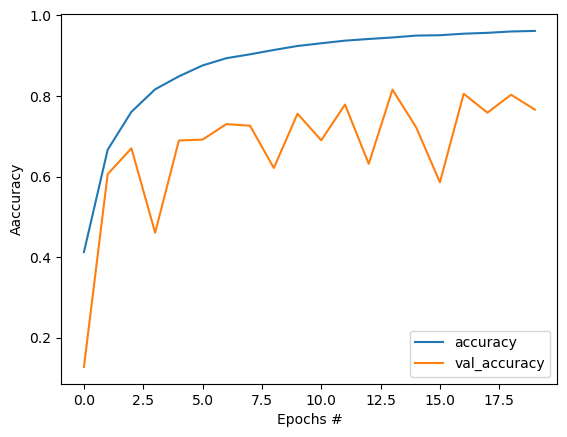

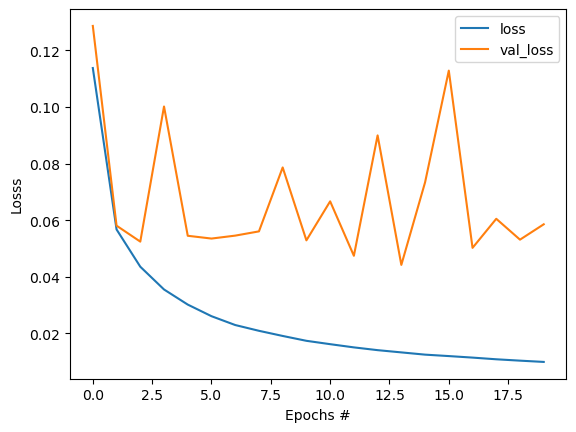

In [9]:
# Plotting
hist = history.history
def show_plt(type):
    if type == 1:
        plt.plot(hist["accuracy"], label="accuracy")
        plt.plot(hist["val_accuracy"], label="val_accuracy")
        plt.ylabel("Aaccuracy")
        plt.xlabel("Epochs #")
        plt.legend()
        plt.show()
    else:
        plt.plot(hist["loss"], label="loss")
        plt.plot(hist["val_loss"], label="val_loss")
        plt.ylabel("Losss")
        plt.xlabel("Epochs #")
        plt.legend()
        plt.show()
        
show_plt(1)
show_plt(0)

In [12]:
# reset the test_data to start iterating over dataset from scratch
validation_set_aug.reset()
# start to predict
pred = model.predict(validation_set_aug)

110/110 [==============================] - 187s 2s/step


In [15]:
import numpy as np
final_predict = np.argmax(pred,axis=1)
true_data=validation_set_aug.classes

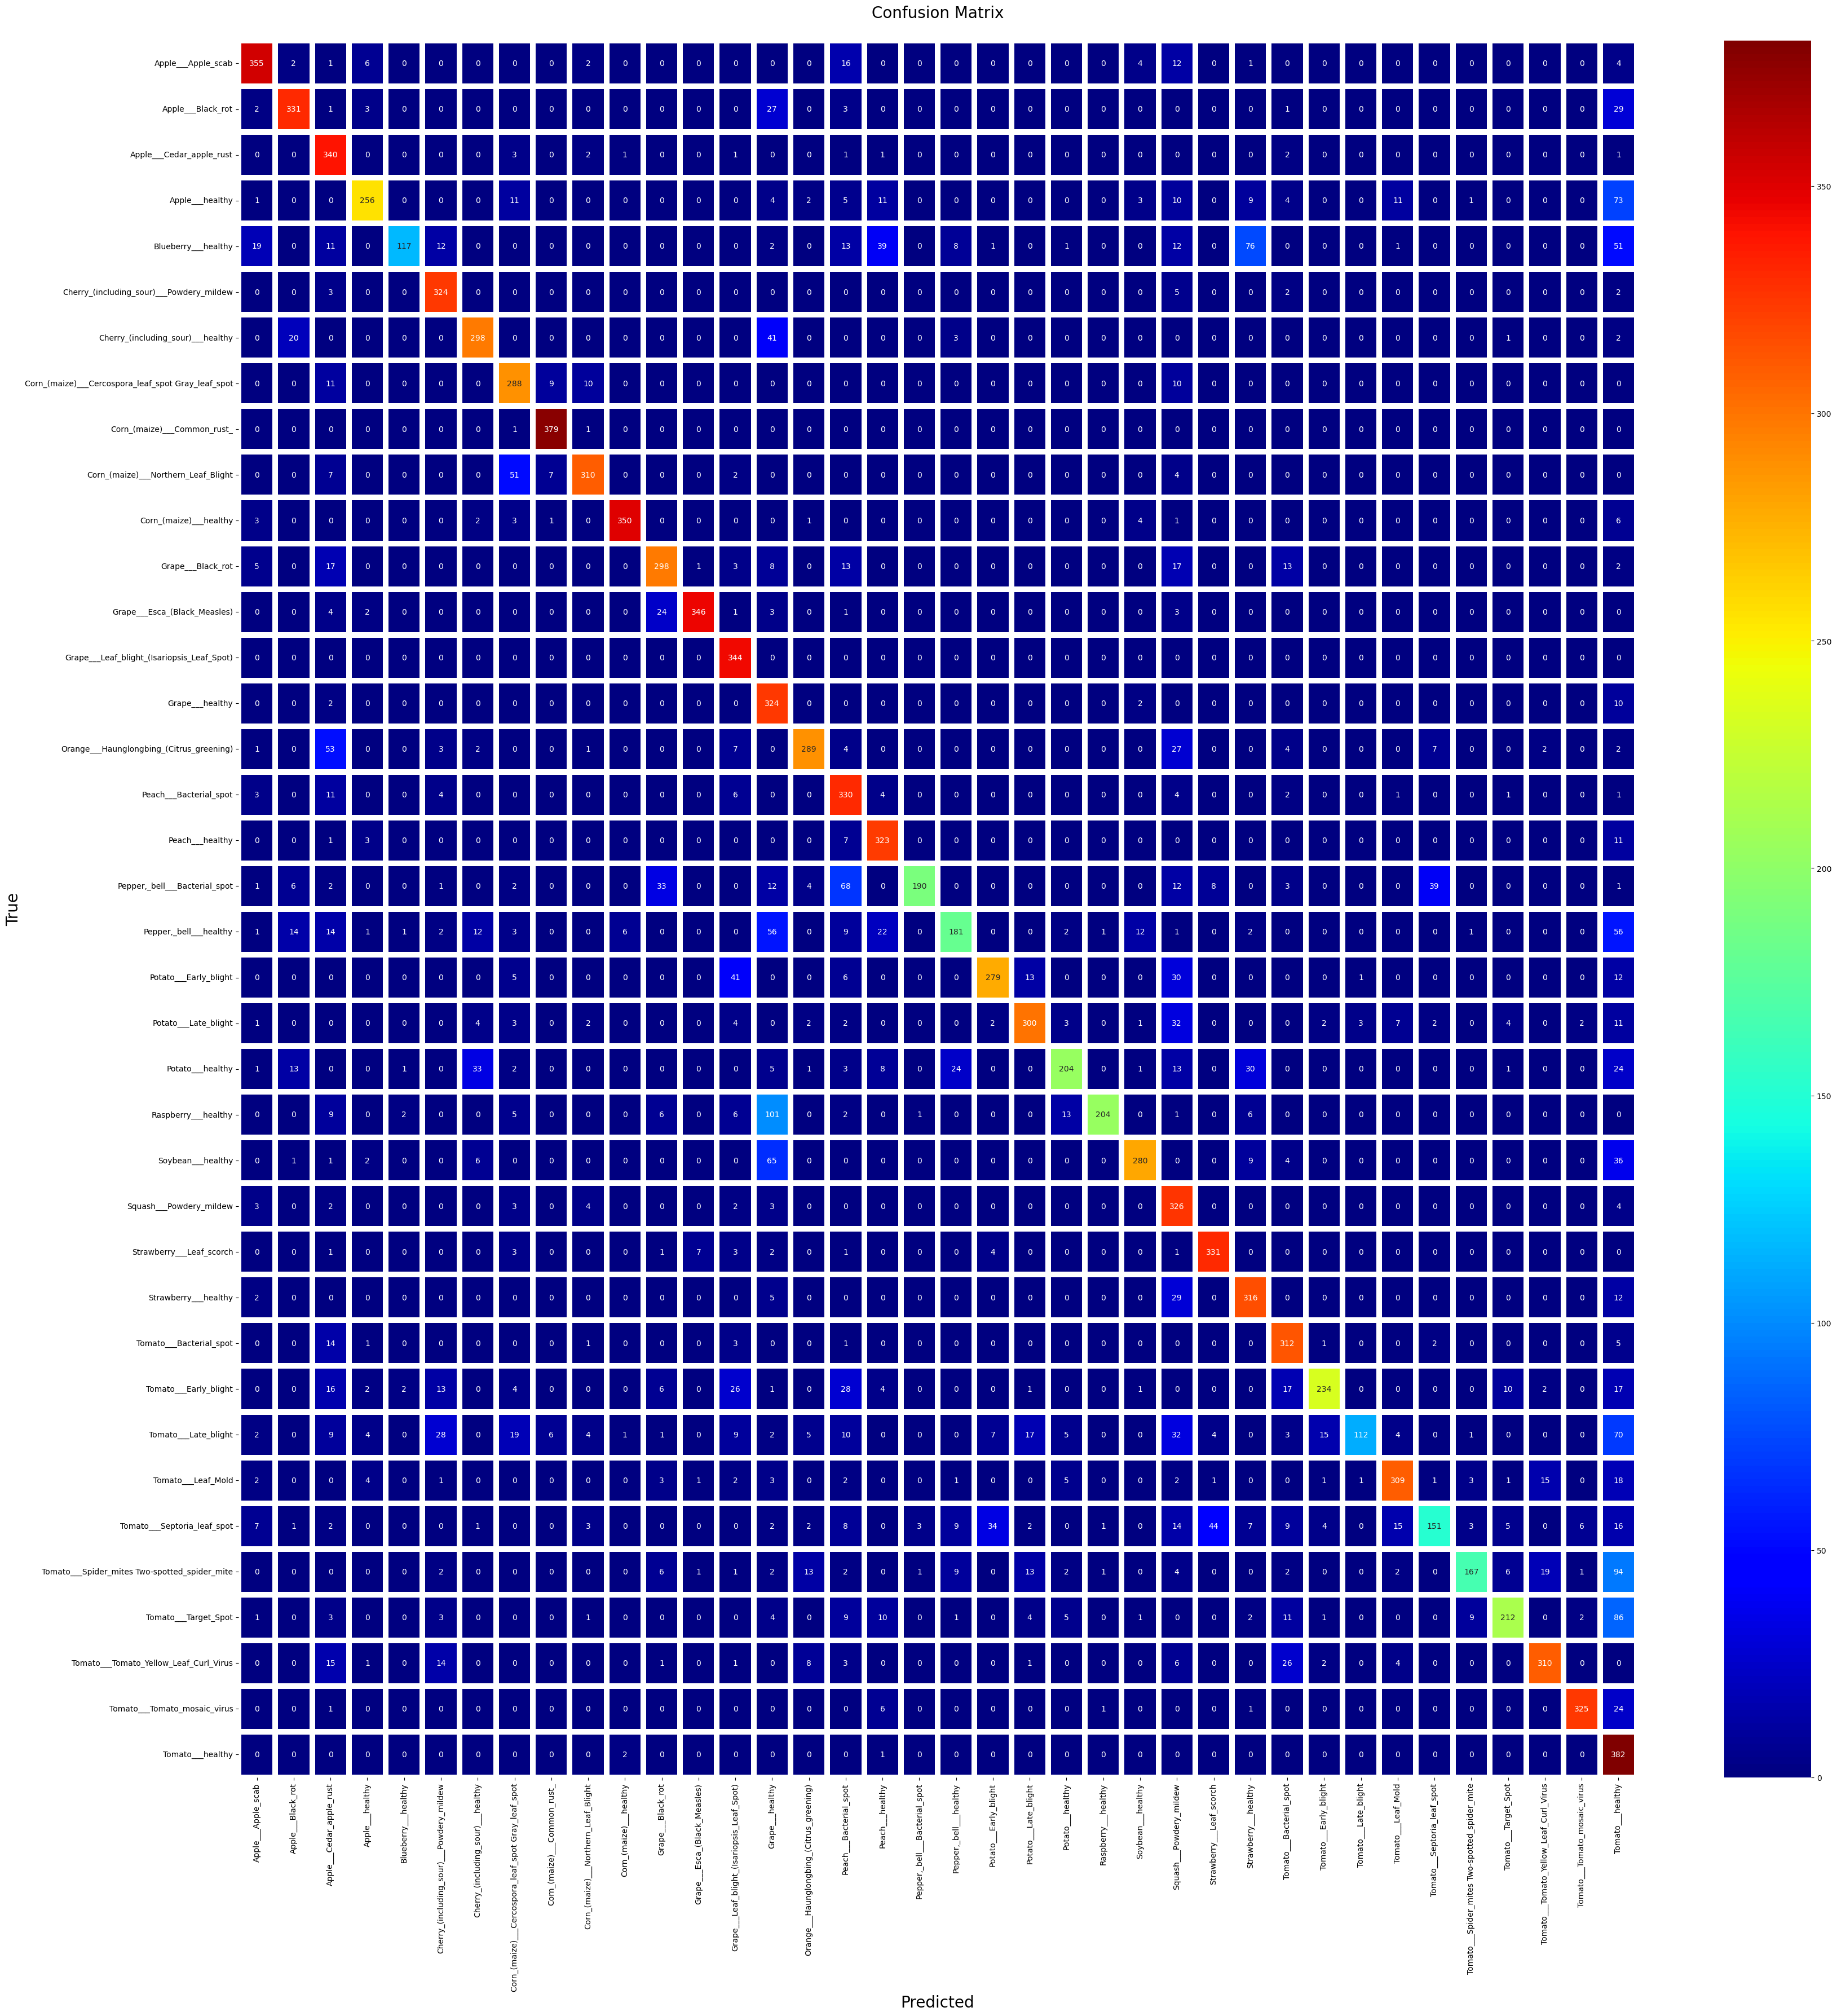

In [21]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(40,40))
confusion = confusion_matrix(true_data, final_predict)
sns.heatmap(confusion, annot=True, fmt='d', cmap='jet',xticklabels=label_map,
            yticklabels=label_map,lw=6)
plt.xlabel('Predicted',fontsize=20,color="black")
plt.ylabel('True',fontsize=20,color="black")
plt.title('Confusion Matrix\n',fontsize=20,color="black")
plt.show()

In [23]:
from sklearn.metrics import classification_report
print(classification_report(true_data, final_predict,target_names=label_map))

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.87      0.88      0.87       403
                                 Apple___Black_rot       0.85      0.83      0.84       397
                          Apple___Cedar_apple_rust       0.62      0.97      0.75       352
                                   Apple___healthy       0.90      0.64      0.75       401
                               Blueberry___healthy       0.95      0.32      0.48       363
          Cherry_(including_sour)___Powdery_mildew       0.80      0.96      0.87       336
                 Cherry_(including_sour)___healthy       0.83      0.82      0.82       365
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.71      0.88      0.78       328
                       Corn_(maize)___Common_rust_       0.94      0.99      0.97       381
               Corn_(maize)___Northern_Leaf_Blight       0.91      0.81      0.

In [26]:
from sklearn.metrics import accuracy_score
acc_score = accuracy_score(true_data,final_predict)
print(f'Accuracy Score: {acc_score:.4f}')

Accuracy Score: 0.7638


In [27]:
class_dict = training_set_aug.class_indices
print(class_dict)

{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___Leaf_scorch': 26, 'Strawberry___healthy': 27, 'Tomato___Bacterial_spot': 28, 'Tomato___Early_blight': 29, 'Tomato___Late_blight': 30, 'Tomato

In [28]:
li = list(class_dict.keys())
print(li)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

Following is our prediction:
1/1 [==============================] - 0s 19ms/step


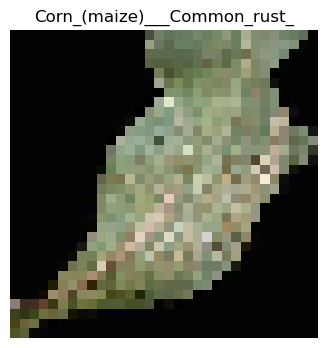

In [33]:
# predicting an image
from tensorflow.keras.preprocessing import image

image_path = "/kaggle/input/new-plant-diseases-dataset/test/test/CornCommonRust1.JPG"
new_img = image.load_img(image_path, target_size=(32,32,3))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
img = img/255

print("Following is our prediction:")
prediction = model.predict(img)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
d = prediction.flatten()
j = d.max()
for index,item in enumerate(d):
    if item == j:
        class_name = li[index]

##Another way
#img_class = classifier.predict_classes(img)
#img_prob = classifier.predict_proba(img)
#print(img_class ,img_prob )


#ploting image with predicted class name        
plt.figure(figsize = (4,4))
plt.imshow(new_img)
plt.axis('off')
plt.title(class_name)
plt.show()

In [34]:
#saving model
filepath="AlexNetModel.hdf5"
model.save(filepath)

In [46]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [47]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

In [48]:
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [58]:
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(training_set_aug,verbose=1)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

440/440 [==============================] - 736s 2s/step - loss: 0.0564 - accuracy: 0.7727
accuracy: 77.27%
